In [2]:
import os
import nibabel as nib
import pylab as plt
import numpy as np
from functions import *
from classes import *

# Introduction
- [ ] To do

In [3]:
proj_root = parent_directory()
print(proj_root)
input_filepath = os.path.join(proj_root, "media/sub-01/anat/sub-01_T2w.nii.gz")
output_folder = os.path.join(proj_root, "output/")
fmri = MRI_Anat(input_filepath)

/Users/joachimpfefferkorn/repos/neurovolume


# Data From the Scanner
Observe below how flattened the data is. Our first goal will be to take these squashed voxels and "inflate" them to an anatomically accurate volume.
- [ ] TODO: expand this note

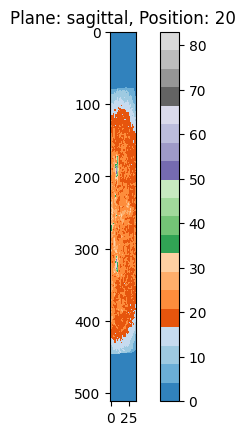

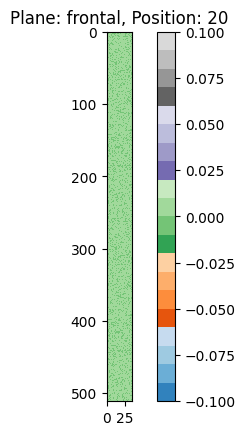

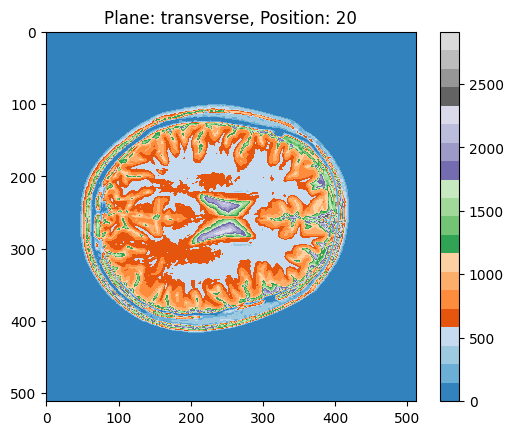

In [4]:
fmri.view_slice(plane="sagittal")
fmri.view_slice(plane="frontal")
fmri.view_slice(plane="transverse")

# Affine Transforms

[relevant NiBabel Documentation](https://nipy.org/nibabel/coordinate_systems.html)
As we can see from the above work and visualizations, our volume does not account for $z$ depth. We need to use the affine to transform this voxel data into an anatomically accurate volume.

Let's call this new volume `anat_vol`. It will hold an anatomically accurate volume of each voxel corresponding a specific part of the brain as it existed in the scanner. As per NiBabel specifications, will be in $RAS+$ space, meaning $Right$, $Anterior$, $Superior$, are all positive values along these ordered axis. This 

*Mild Extrapolation*: the raw voxel data seems to iterate each slice by just one integer, thus encoding order but not exact position. This particular scan seems to have taken slices down the saggital ($z$) plane. Thus the brain appears to be vertically squashed down. The affine stored in this header will "inflate" the brain to it's anatomically accurate, real-life, geometry

The $4 \times 4$ image $affine$ array stored in `brain_img.affine` can be used to get this accurate geometry.
This affine includes the following:
- Combined zoom and rotation matrices (seen here in the $m_{\:row,\: column}$)
- Translation units $a$, $b$, and $c$
- An additional row of $[0,0,0,1]$ to create homogenous coordinates (allows us to have both translation, rotation, and zooms in the same matrix)

$$\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a\\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1
\end{bmatrix}$$


In [5]:
print(f"Affine:\n{fmri.brain_img.affine}\n")
zoom_rotation = fmri.brain_img.affine[:3, :3]
transform = fmri.brain_img.affine[:3, 3:]
print(f"Zoom and Rotation (M):\n{zoom_rotation}\nTransform (a,b,c):\n{transform}")

Affine:
[[  -0.5           0.           -0.          129.70300293]
 [  -0.            0.5          -0.         -110.68299866]
 [   0.            0.            4.          -74.83930206]
 [   0.            0.            0.            1.        ]]

Zoom and Rotation (M):
[[-0.5  0.  -0. ]
 [-0.   0.5 -0. ]
 [ 0.   0.   4. ]]
Transform (a,b,c):
[[ 129.70300293]
 [-110.68299866]
 [ -74.83930206]]


For convenience sake, we usually break the affine matrix into it's components $M$ and $(a,b,c)$. (Otherwise we would have to add an additional 1 to our input and output coordinates).
In the following equation:
- $x,y,z$ are our output `anat_vol` voxel coordinates
- $M$ is our combined zoom and rotation matrices
- $i,j,k$ are our raw input voxels coordinates
- $a,b,c$ make up our translation offset coordinates


$$\begin{bmatrix} x\\ y \\ z \end{bmatrix} = M \begin{bmatrix} i\\ j \\ k \end{bmatrix} + \begin{bmatrix} a\\ b \\ c \end{bmatrix}$$

*However*, `apply_affine` [does](https://textbook.nipraxis.org/nibabel_apply_affine.html) 

In [6]:
from nibabel.affines import apply_affine as apply_affine

# Quick Linear Algebra and Tensor Brushup
Had a very clarifying talk with Camille at RC

Each voxel (as viewed in the `matplotlib` above) has a certain $value$, which is it's density. It also has a certain position, which is an $x,y,z$ coordinate.

Let's think of the MRI as a list of $4D$ arrays, each one carries the coordinates and position above. Each array will look something like $$[x,y,z,value]$$

In order to transform this volume, we need to apply the affine to each one of these $x,y,z$ coordinates while leaving the $value$ unchanged.

Let's revisit the visualization before:
- [ ] Todo: plot this point with a little circle or something

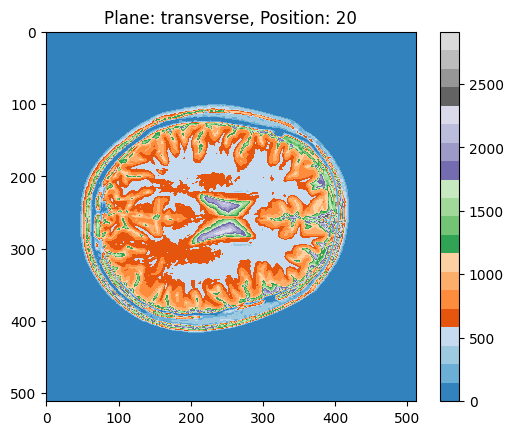

539.0142627060413


In [7]:
fmri.view_slice(plane="transverse")
print(fmri.brain_data[200,200,20])

We see here that the $coordinates$ `200,200,200` hold the $value$ `539.01...`
This checks out when we look at the corresponding region in the image $x=200,y=200,z=20$ is the lightest blue ($z$ being the position of the slice). This color corresponds to the range the holding `539.01...`

From the following test, we can see that the apply affine does indeed change the coordinates for a list of $3D$ arrays:

In [8]:
print(apply_affine(fmri.brain_img.affine, np.array([[0, 1, 2], [2, 2, 4], [3, -2, 1], [5, 3, 1]])))

[[ 129.70300293 -110.18299866  -66.83930206]
 [ 128.70300293 -109.68299866  -58.83930206]
 [ 128.20300293 -111.68299866  -70.83930206]
 [ 127.20300293 -109.18299866  -70.83930206]]


First, we need to [re-shape it](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) so it's a $3 \times n$ array

In [10]:
print(fmri.brain_img.shape)
print(fmri.brain_data[:,:,20][99:101])
print(fmri.brain_img.shape[0])

(512, 512, 35)
[[0.         0.         5.01542683 ... 0.         0.         0.        ]
 [0.         0.         5.01542683 ... 0.         0.         0.        ]]
512


# Naive Affine Implementation

I am betting there is a better way to do this, but for now this is the only way I can think of applying this affine. It certainly does not seem like it will be very computationally efficient. Sans GPU the time $O(n)$ is probably going to scale linearly (which I don't love) but other than that I actually think this might be a good idea. Here's why:

Copilot provided a typically cocky solution I did not understand. There may also be some similar cargo-cult solutions floating online. However -for now- I think it is worth to do this naively as it is more maintainable. (For you sci-fi nerds; think of Yul's gas stove in Anathem). We don't need this to be especially performant as of now and laying this all out in a hyper readable way means that even linear-algebra philistines such as myself will be able to grasp what's going on here. 

All that being said, here's the plan:
1. Iterate through each point in the 3D Tensor (ouch) and append each $x,y,z,value$ as the (somewhat weird) tuple `([x,y,z],value)` to a list
2. Iterate through this list and apply the affine transformation to each `[x,y,z]`
3. Create a new volume from this list

Due to the computationally expensive nature of this naive implementation, let's build this function up from sub-functions one by one, saving our data in this notebook.

In [11]:
def gather_points(img):
    input_data = img.get_fdata() #redundant with the class, but this makes it universal
    voxels = []
    for i in range(input_data.shape[0]):
        for j in range(input_data.shape[1]):
            for k in range(input_data.shape[2]):
                voxels.append(([i, j, k], input_data[i, j, k]))
    return voxels

input_voxels = gather_points(fmri.brain_img)

In [14]:
unique_x_vals = []
unique_y_vals = []
unique_z_vals = []
for voxel in input_voxels[500:510]:
    if voxel[0][0] not in unique_x_vals:
        print(voxel[0])
    # moved_voxel = apply_affine(fmri.brain_img.affine, voxel[0]), voxel[1]
    # print(moved_voxel)

[0, 14, 10]
[0, 14, 11]
[0, 14, 12]
[0, 14, 13]
[0, 14, 14]
[0, 14, 15]
[0, 14, 16]
[0, 14, 17]
[0, 14, 18]
[0, 14, 19]


In [13]:
def move_points(affine, voxels):
    moved = []
    for voxel in voxels:
        # new pos = apply_affine(voxel)
        # new_coords = apply_affine(affine, voxel[0])
        # print(voxel)
        # print(new_coords)
        moved_voxel = apply_affine(affine, voxel[0]), voxel[1]
        moved.append(moved_voxel)
    return moved

moved = move_points(fmri.brain_img.affine, input_voxels)


# Have I painted myself into a corner?
So now we have a ton of `xyz` coordinates and corresponding values . Which is great! However, this means that all the values are no longer arranged on an evenly spaced grid!

In [72]:
print(moved[5000:5010])

[(array([129.70300293, -39.68299866,  45.16069794]), np.float64(0.0)), (array([129.70300293, -39.68299866,  49.16069794]), np.float64(0.0)), (array([129.70300293, -39.68299866,  53.16069794]), np.float64(0.0)), (array([129.70300293, -39.68299866,  57.16069794]), np.float64(0.0)), (array([129.70300293, -39.68299866,  61.16069794]), np.float64(0.0)), (array([129.70300293, -39.18299866, -74.83930206]), np.float64(0.0)), (array([129.70300293, -39.18299866, -70.83930206]), np.float64(0.0)), (array([129.70300293, -39.18299866, -66.83930206]), np.float64(0.0)), (array([129.70300293, -39.18299866, -62.83930206]), np.float64(0.0)), (array([129.70300293, -39.18299866, -58.83930206]), np.float64(0.0))]


In [68]:
unique_x_vals = []
unique_y_vals = []
unique_z_vals = []
for coord in moved[:20]:
    x = float(coord[0][0])
    y = float(coord[0][1])
    z = float(coord[0][2])
    if x not in unique_x_vals:
        unique_x_vals.append(x)
    if y not in unique_y_vals:
        unique_y_vals.append(y)
    if z not in unique_z_vals:
        unique_z_vals.append(z)
print(unique_x_vals)
print(unique_y_vals)
print(unique_z_vals)

[129.7030029296875]
[-110.68299865722656]
[-74.83930206298828, -70.83930206298828, -66.83930206298828, -62.83930206298828, -58.83930206298828, -54.83930206298828, -50.83930206298828, -46.83930206298828, -42.83930206298828, -38.83930206298828, -34.83930206298828, -30.83930206298828, -26.83930206298828, -22.83930206298828, -18.83930206298828, -14.839302062988281, -10.839302062988281, -6.839302062988281, -2.8393020629882812, 1.1606979370117188]
